In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import statsmodels.api as sma
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import scipy.stats as stats

In [2]:
#Helper Functions

#############
def compute_tangency_risk_free(df_tilde, diagonalize_Sigma=False):
    #input:df->matrix of excess returns over risk free rate
    #output:tangency weight, non annualized individual portfolio mean, non annualized covariance matrix
    Sigma = df_tilde.cov()

    # N is the number of assets

    N = Sigma.shape[0]

    Sigma_adj = Sigma.copy()

    if diagonalize_Sigma:

        Sigma_adj.loc[:,:] = np.diag(np.diag(Sigma_adj))

    mu_tilde = df_tilde.mean()

    Sigma_inv = np.linalg.inv(Sigma_adj)

    weights = Sigma_inv @ mu_tilde / (np.ones(N) @ Sigma_inv @ mu_tilde)

    omega_tangency = pd.Series(weights, index=mu_tilde.index)
    
    return omega_tangency, mu_tilde, Sigma_adj


def target_mv_portfolio_risk_free(df_tilde, target_return=0.01, diagonalize_Sigma=False):
    
    #input:df->matrix of non annualized excess returns over risk free rate
    #target: excess risk free return sought non annualized
    #output: target portfolio weights, non annualized tangency mean, non annualized cov matrix

    omega_tangency, mu_tilde, Sigma = compute_tangency_risk_free(df_tilde, diagonalize_Sigma=diagonalize_Sigma)

    Sigma_adj = Sigma.copy()

    if diagonalize_Sigma:

        Sigma_adj.loc[:,:] = np.diag(np.diag(Sigma_adj))

    Sigma_inv = np.linalg.inv(Sigma_adj)

    N = Sigma_adj.shape[0]

    delta_tilde = ((np.ones(N) @ Sigma_inv @ mu_tilde)/(mu_tilde @ Sigma_inv @ mu_tilde)) * target_return

    omega_star = delta_tilde * omega_tangency

    return omega_star, mu_tilde, Sigma_adj
#############


def Total_Returns_Tangency_Portfolio(df,annulization_factor):
    
    #df -> matrix of non annualized returns for any number of assets
    #annulization factor -> annulaization required as per data frequency in df
    #output is the weights of each portfolio
    
    columns=df.shape[1]
    sigma=df.cov()*annulization_factor
    sigma_inv=np.linalg.inv(sigma)
    mu_transverse=df.mean()*annulization_factor
    scaling=np.ones(columns)@ sigma_inv @ mu_transverse
    omega_t=(1/scaling) * sigma_inv @ mu_transverse
    return pd.Series(omega_t, index=df.columns)

def Total_Returns_GMV_Portfolio(df,annulization_factor):

    #df -> matrix of non annulaized returns for any number of assets
    #annulization factor -> annulaization required as per data frequency in df
    #output is the weights of each portfolio
    
    columns=df.shape[1]
    sigma=df.cov()*annulization_factor
    sigma_inv=np.linalg.inv(sigma)
    scaling=np.ones(columns)@ sigma_inv @ np.ones(columns)
    omega_v=(1/scaling) * sigma_inv @ np.ones(columns)
    return pd.Series(omega_v, index=df.columns)

def Portfolio_MVS(weights,return_matrix,annulization_factor):

    #weights-> Portfolio weights
    #return_matrix -> non annualized returns data for each asset non annualized
    #annulization factor -> annulaization required as per data frequency in return_matrix
    #output->mean, standard deviation and sharpe ratio (not excess return) based on portfolio weights

    mean=np.dot(weights,return_matrix.mean())*annulization_factor
    vol=np.sqrt(weights@return_matrix.cov()@weights)*(annulization_factor**0.5)
    sharpe=mean/vol
    return mean, vol, sharpe

def Portfolio_Weights_MV_Frontier(mean_target,omega_t_mean,omega_t,omega_v_mean,omega_v):
    
    #mean_targer -> portfolio mean sought
    #omega_t -> tangency portfolio weights
    #omega_t_mean -> tangency portfolio mean
    #omega_v -> minimum variance portfolio weights
    #omega_v_mean -> mean of minimum variance portfolio
    #ouput -> portfolio weights to achieve target mean 
    
    d=(mean_target-omega_v_mean)/(omega_t_mean-omega_v_mean)
    return(d*omega_t+(1-d)*omega_v)



def Max_Drawdown_Stats(df,window):
    
    #input datafram of returns with index being datetime objects, columns being periodic(any) returns of each security
    #rolling window for MDD
    #output is dataframe. The columns are Max_Drawdown, Max_Drawdown_Date, Previous_Peak, Recovery_Peak, 
    # with index same as columns of orginal data frame. 
    
    new_df = (1+df).cumprod()
    columns=new_df.columns.tolist()
    new_df=new_df/new_df.rolling(window, min_periods=1).max()

    minValueIndex = new_df.idxmin()
    minValue=new_df.min()

    row_date={}
    date_row={}
    for i,n in enumerate(new_df.index):
        row_date[i]=n
        date_row[n]=i

    new_df["row"]=new_df.index.map(date_row)
    Previous_Peak=[]
    Next_Peak=[]

    for col in columns:
        new_df["Previous_Peak"]=np.where(new_df[col]==1,new_df.row,np.nan)
        new_df["Next_Peak"]=new_df.Previous_Peak
        new_df[['Previous_Peak']] = new_df[['Previous_Peak']].ffill(axis=0)
        new_df[['Next_Peak']] = new_df[['Next_Peak']].bfill(axis=0)
        new_df.Previous_Peak=new_df.Previous_Peak.map(row_date)
        new_df.Next_Peak=new_df.Next_Peak.map(row_date)
        Previous_Peak.append(new_df[new_df.index==minValueIndex[col]]['Previous_Peak'][0])
        Next_Peak.append(new_df[new_df.index==minValueIndex[col]]['Next_Peak'][0])

    Table=pd.DataFrame({'Max_Drawdown':minValue-1,'Max_Drawdown_Date':minValueIndex})
    Table['Previous_Peak']=Previous_Peak
    Table['Recovery_Peak']=Next_Peak
    Table.Recovery_Peak=np.where(Table.Recovery_Peak<Table.Max_Drawdown_Date,np.datetime64("NaT"),Table.Recovery_Peak)
    return Table

def Portfolio_Single_Variable_Regression(df,n,risk_free_rate,annulization_factor):
    #df -> matrix of assets returns
    #n -> to show which column is the independent variable n->{0,len(df)-1}
    #risk_free_rate -> dataframe with index same as df and one column for riskfree rate.
    #output -> beta and intercept term as columns and dependent variables( excluding the nth column) as rows 
    #output -> information ratio and treynor ratio
    
    columns = df.columns.tolist()
    independent_variable_name=columns[n]
    independent_variable=df[columns[n]].tolist()
    independent_variable_mean=df[columns[n]].mean()
    
    del columns[n]
    beta=[]
    intercept=[]
    Tracking_Error=[]
    Excess_Return_Over_Benchmark=[]
    results=[]
    
    for col in columns:
        A=df[col].tolist()
        B=independent_variable
        new_df=pd.DataFrame({'A':A,'B':B})
        result=sm.ols(formula="A ~ B",data=new_df).fit()
        results.append(result)
        beta.append(result.params[1])
        intercept.append(result.params[0])
        
        
        Tracking_Error.append(result.resid.std()*(annulization_factor**0.5))
        Excess_Return_Over_Benchmark.append(result.params[0]*annulization_factor)
        
    Table=pd.DataFrame(index=columns)
    Table["Beta"]=beta
    Table["Intercept"]=intercept
    
    new_df=df[columns]
    Table["Treynor_Ratio"]=new_df.sub(risk_free_rate[risk_free_rate.columns[0]], axis=0).mean()*annulization_factor/Table.Beta
    Table["Information_Ratio"]=[x/y for x,y in zip(Excess_Return_Over_Benchmark,Tracking_Error)]
    
    return Table, results

def Multivariate_Regression(df,intercept=True):
    new_df=df.copy()
    columns=new_df.columns.tolist()

    if not intercept:
        formula=columns[len(columns)-1]+" ~ -1"
        for col in columns[0:len(columns)-1]:
            formula+=" + "+col
        result=sm.ols(formula=formula,data=new_df).fit()
        Table=pd.DataFrame(index=(columns[0:len(columns)-1]))
    else:

        formula=columns[len(columns)-1]+" ~ "
        for col in columns[0:len(columns)-1]:
            formula+=" + "+col
        result=sm.ols(formula=formula,data=new_df).fit()
        Table=pd.DataFrame(index=(["Intercept"]+columns[0:len(columns)-1]))

    Table["Coeffcient"]=result.params.tolist()
    return Table, result

def Rolling_Regression_Prediction(df,window,start_index):
    #df -> matrix of return exactly as Multivariate_Regression(df)
    #start_index -> start point to commence regression
    #window -> the rolling window of regression
    #prediction is made for every subsequent period and the rolled
    #returns predicted and actual dependent variables
    
    Predicted=[]
    Actual=[]
    while window+start_index <= len(df)-1:
        
        train_df=df[start_index:start_index+window]
        test_df=df[start_index+window:start_index+window+1]
        test_df.insert(loc=0, column='Ones', value=1)

        Table,result=Multivariate_Regression(train_df)
        Coefficient=np.array(Table.Coeffcient)

        OOS_Dependent_Variable=test_df.iat[0, test_df.shape[1]-1]
        OOS_Independent_Variables=np.array(test_df.iloc[:,0:test_df.shape[1]-1].T).flatten()
        Predicted_Dependent_Variable=np.dot(OOS_Independent_Variables,Coefficient)
        
        Predicted.append(Predicted_Dependent_Variable)
        Actual.append(OOS_Dependent_Variable)
        start_index+=1
    
    Table=pd.DataFrame({"Predicted":Predicted,"Actual":Actual})
    return Table

def Prediction_Statistics(df):
    
    #input-> the table from Rolling_Regression_Prediction
    #output-> returns mean/stdev/z-stat of predicted, actual, diff, diff_percent, correl between actual and explained
    df['diff']=df.Predicted-df.Actual
    df['diff_percent']=df["diff"] / df["Actual"]
    df.diff_percent=np.where(abs(df.diff_percent)==np.inf,0,df.diff_percent)
    
    Table=pd.DataFrame({'Mean':df.mean(),"STDEV":df.std(),"Mean/STDEV":df.mean()/df.std()})
    return df.corr().iloc[0:2,0:2], Table

def probability(h,mean,sigma):
    #input h -> number of periods of cumulation enters as list of numbers to be tested
    #mean -> mean log return
    #sigma -> std of log return
    #output -> dataframe with h as index and probability of mean <0
    
    df=pd.DataFrame({'h':h})
    df["Probabilty"]=stats.norm.cdf(-(df.h**0.5)*mean/sigma)
    return df.set_index('h')

def check_factor_model(portfolios,factors):
    
    col=["Intercept"]+factors.columns.tolist()
    col_fact=[]
    for c in col:
        col_fact.append([])
    portfolio_list=portfolios.columns.tolist()
    Intercept=[]
    RSq=[]
    
    for portfolio in portfolio_list:
        Table,result=Multivariate_Regression(factors.merge(portfolios[[portfolio]],left_index=True,right_index=True))
        for i,r in enumerate(result.params):
            col_fact[i].append(r)        
        RSq.append(result.rsquared)
    Table=pd.DataFrame(index=portfolio_list)
    for i,c in enumerate(col):
        Table[c]=col_fact[i]
    Table["R_Squared"]=RSq
    return Table

def summary_stats(umd,factors):
    result=[]
    umd.columns=['UMD']
    result.append(umd.mean()[0]*12)
    result.append(umd.std()[0]*(12**0.5))
    result.append(result[0]/result[1])
    result.append(umd.skew()[0])
    result.append(umd.UMD.corr(factors.MKT))
    result.append(umd.UMD.corr(factors.HML))
    return result

In [3]:
umd=pd.read_excel("momentum_data.xlsx",sheet_name="momentum (excess returns)")
factors=pd.read_excel("momentum_data.xlsx",sheet_name="factors (excess returns)")
rf=pd.read_excel("momentum_data.xlsx",sheet_name="risk-free rate")
size_sorts=pd.read_excel("momentum_data.xlsx",sheet_name="size_sorts (total returns)")
deciles=pd.read_excel("momentum_data.xlsx",sheet_name="deciles (total returns)")

umd.set_index('Date',inplace=True)
factors.set_index('Date',inplace=True)
rf.set_index('Date',inplace=True)
size_sorts.set_index('Date',inplace=True)
deciles.set_index('Date',inplace=True)

size_sorts.columns=[i.replace(" ","_") for i in size_sorts.columns.tolist()]
deciles.columns=[i.replace(" ","_") for i in deciles.columns.tolist()]

pd.read_excel("momentum_data.xlsx",sheet_name="descriptions")

,Unnamed: 0,Name,Unit,Construction,Description
0,MKT,Market,Excess Return,Market-cap-weighted,US Equities
1,SMB,Size,Excess Return,Small Minus Big,Long small stocks and short big stocks
2,HML,Value,Excess Return,High Minus Low,Long value (high book-to-market) stocks and sh...
3,RF,Risk-free rate,Total Return,Tbills,NaN
4,SMALL LoPRIOR,Small Down,Total Return,Small Losers,Bottom 3 deciles and Small
5,SMALL HiPRIOR,Small Up,Total Return,Small Winners,Top 3 deciles and Small
6,BIG LoPRIOR,Big Down,Total Return,Big Losers,Bottom 3 deciles and Big
7,BIG HiPRIOR,Big Up,Total Return,Big Winners,Top 3 deciles and Big


# Section 2 : Investigating Momentum

**1. Is momentum still profitable?**

(a) Using the data provided, fill in Table 1 with the appropriate stats

(b) Has momentum changed much over time, as seen through these subsample statistics? **-> Momentum has changed remarkably in 2009-2022 with the mean return being negative. Skew and correlations to MKT and HML appear to be on the lower side during the period 1994-2008. All other stats in othe rperiods are comparable**

(c) Does this data support AQR’s argument that momentum is an important piece of the ideal portfolio? What if mean returns to momentum are in actuality near zero due to transaction costs—would there still be evidence here that momentum is valuable **-> UMD displays overall positive returns and lower correlation to HML and MKT and therefore is still valuable. The final inclusion in a portfolio should more importantly look at correlations with other assets to judge inclusion/exclusion.**

In [4]:
Table1=pd.DataFrame(index=['Mean', 'Vol', 'Sharpe', 'Skewness', 'MKT_Corr', 'HML_Corr'])
Table1["1927-2022"]=summary_stats(umd,factors)
Table1["1927-1993"]=summary_stats(umd.loc['1927':'1993',:],factors.loc['1927':'1993',:])
Table1["1994-2008"]=summary_stats(umd.loc['1994':'2008',:],factors.loc['1993':'2008',:])
Table1["2009-2022"]=summary_stats(umd.loc['2009':,:],factors.loc['2009':,:])
Table1.T

,Mean,Vol,Sharpe,Skewness,MKT_Corr,HML_Corr
1927-2022,0.077274,0.162650,0.475096,-3.015478,-0.344803,-0.417622
1927-1993,0.090113,0.159991,0.563242,-3.808977,-0.362537,-0.494960
1994-2008,0.104373,0.175551,0.594548,-0.582038,-0.234519,-0.130707
2009-2022,-0.014851,0.159280,-0.093238,-2.811558,-0.377934,-0.385203


**2. The case is about whether a long-only implementation of momentum is valuable. Construct your own long-only implementation**

(a) Fill out Table 2 for the data in the period 1994-2022.

(b) Is long-only momentum as attractive as long-short momentum with respect to mean, volatility, and Sharpe Ratio ? **-> The long only momentum significantly outperforms long-short momentum with respect to mean and sharpe. Notably, the vol of the long-short is expectedly lower, albeit marginally**

(c) Is long-only momentum as diversifying as long-short momentum with respect to market and value premia? **-> Long only does well with respect to HML correlation wise. However, it is higly correlated with MKT and therefore not a great diversifier as compared to long-short**

(d) Show a plot of the cumulative product of 1 + ˜rmom:FF and 1 + ˜rmomU:FF over the 1994-2022 subsample.2


In [5]:
size_sorts["Long-only"]=0.5*(size_sorts.SMALL_HiPRIOR + size_sorts.BIG_HiPRIOR)-rf.RF
Table2=pd.DataFrame(index=['Mean', 'Vol', 'Sharpe', 'Skewness', 'MKT_Corr', 'HML_Corr'])
Table2["Long-and-short"]=summary_stats(umd.loc['1994':,:],factors.loc['1994':,:])
Table2["Long-only"]=summary_stats(size_sorts[["Long-only"]].loc['1994':,:],factors.loc['1994':,:])
Table2.T

,Mean,Vol,Sharpe,Skewness,MKT_Corr,HML_Corr
Long-and-short,0.047353,0.168605,0.280852,-1.433554,-0.306139,-0.238601
Long-only,0.112783,0.178903,0.630411,-0.482872,0.903499,-0.154667


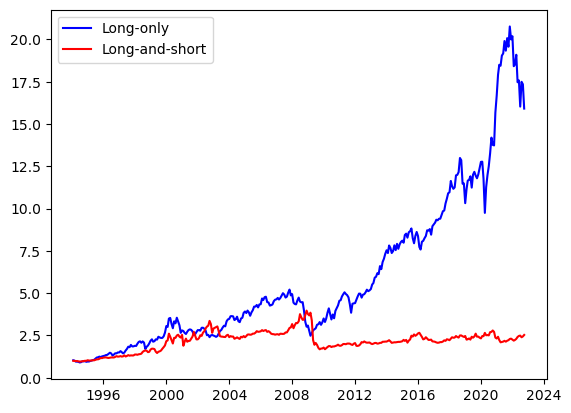

In [6]:
Exhibit3=(1+size_sorts[["Long-only"]].loc['1994':,:]).cumprod()
Exhibit3["Long-and-short"]=(1+umd.loc['1994':,:]).cumprod()
plt.plot(Exhibit3["Long-only"],color='blue')
plt.plot(Exhibit3["Long-and-short"],color='red')
plt.legend(['Long-only', 'Long-and-short'])

**3. Is momentum just data mining, or is it a robust strategy?**


(a) Compare all three constructions, (in the full-sample period,) by filling out the stats in the table below for the period 1994-2022.

(b) Do the tradeoffs between the 1-decile, 3-decile, and 5-decile constructions line up with the theoretical tradeoffs we discussed in the lecture? **-> Yes, they do line up. As we increase the decile our returns fall and vol increases and therefore sharpe ratios also decline, with other stats staying in the same range for all 3 constructions.**

(c) Should AQR’s retail product consider using a 1-decile or 5-decile construction? **-> The 1-decile option has the maximum sharpe and lowest trading cost and therefore AQR should use this option over the 5-decile option.**

(d) Does ˜r momD3 have similar stats to the Fama-French construction in (1). Recall that construction is also a 3-decile, long-short construction, but it is segmented for small and large stocks. Compare the middle row of Table 3 with the top row of Table. **-> The Fama-French construction has similar correlations with MKT and HML and higher sharpe due to higher mean and lower vol and therefore appears to be a better construction than D3**

In [7]:
mom_test=pd.DataFrame(index=deciles.index)
mom_test["D1"]=deciles.Hi_PRIOR-deciles.Lo_PRIOR
mom_test["D3"]=(deciles.Hi_PRIOR+deciles.PRIOR_9+deciles.PRIOR_8 - \
                deciles.PRIOR_3-deciles.PRIOR_2-deciles.Lo_PRIOR)/3
mom_test["D5"]=(deciles.Hi_PRIOR+deciles.PRIOR_9+deciles.PRIOR_8 \
                +deciles.PRIOR_7+deciles.PRIOR_6 -deciles.PRIOR_5 \
                -deciles.PRIOR_4-deciles.PRIOR_3-deciles.PRIOR_2 \
                -deciles.Lo_PRIOR)/5

Table3=pd.DataFrame(index=['Mean', 'Vol', 'Sharpe', 'Skewness', 'MKT_Corr', 'HML_Corr'])
Table3["D1"]=summary_stats(mom_test[['D1']].loc['1994':,:],factors.loc['1994':,:])
Table3["D3"]=summary_stats(mom_test[['D3']].loc['1994':,:],factors.loc['1994':,:])
Table3["D5"]=summary_stats(mom_test[['D5']].loc['1994':,:],factors.loc['1994':,:])
Table3.T

,Mean,Vol,Sharpe,Skewness,MKT_Corr,HML_Corr
D1,0.079409,0.297952,0.266515,-1.323613,-0.335574,-0.236392
D3,0.034203,0.192568,0.177615,-1.355380,-0.365386,-0.229882
D5,0.018031,0.134026,0.134536,-1.435409,-0.357936,-0.227501


**4. Does implementing momentum require trading lots of small stocks—thus causing even larger trading costs?**

(a) Fill out Table 4 over the sample 1994-2022.

(b) Is the attractiveness of the momentum strategy mostly driven by the small stocks? That is, does a momentum strategy in large stocks still deliver excess returns at comparable risk? **No the risk is comparable, but big is preferable.**

In [8]:
mom_test2=pd.DataFrame(index=size_sorts.index)
mom_test2["Small"]=size_sorts.SMALL_HiPRIOR-size_sorts.SMALL_LoPRIOR-rf.RF
mom_test2["Big"]=size_sorts.BIG_HiPRIOR-size_sorts.BIG_LoPRIOR-rf.RF

Table4=pd.DataFrame(index=['Mean', 'Vol', 'Sharpe', 'Skewness', 'MKT_Corr', 'HML_Corr'])
Table4["All"]=summary_stats(umd.loc['1994':,:],factors.loc['1994':,:])
Table4["Small"]=summary_stats(mom_test2[["Small"]].loc['1994':,:],factors.loc['1994':,:])
Table4["Big"]=summary_stats(mom_test2[["Big"]],factors.loc['1994':,:])
Table4.T

,Mean,Vol,Sharpe,Skewness,MKT_Corr,HML_Corr
All,0.047353,0.168605,0.280852,-1.433554,-0.306139,-0.238601
Small,0.041092,0.170917,0.240422,-1.780275,-0.306489,-0.167060
Big,0.031323,0.179299,0.174698,-2.292313,-0.276750,-0.288883


**5. In conclusion, what is your assessment of the AQR retail product? Is it capturing the important features of the Fama-French construction of momentum? Would you suggest any modifications?** **-> The construction is very different as long only therefore very correlated with MKT**